In [1]:
!pip install torch-geometric
!pip install node2vec

In [2]:
import pandas as pd
df_identity = pd.read_csv('ieee_train_identity.csv')
df_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [3]:
df_transaction = pd.read_csv('ieee_train_transaction.csv')
df_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df_merged = pd.merge(df_transaction, df_identity, on="TransactionID", how="left")
df_merged.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [5]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch_geometric.data import Data, HeteroData
from torch_geometric.nn import GCNConv
from node2vec import Node2Vec
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve, average_precision_score
import random
from sklearn.cluster import KMeans, DBSCAN
import warnings
import gc
warnings.filterwarnings('ignore')

In [36]:
MAX_TRANSACTIONS = 590540  # can lower the transactions if required for the 

In [37]:
def load_data(sample_size=MAX_TRANSACTIONS):
    try:
        df_transaction = pd.read_csv('ieee_train_transaction.csv')
        print(f"Loaded transaction data with {df_transaction.shape[0]} rows and {df_transaction.shape[1]} columns")

        try:
            df_identity = pd.read_csv('ieee_train_identity.csv')
            print(f"Loaded identity data with {df_identity.shape[0]} rows and {df_identity.shape[1]} columns")

            print("Merging datasets")
            df_merged = pd.merge(df_transaction, df_identity, on="TransactionID", how="left")

        except Exception as e:
            print(f"Error loading identity data: {e}")
            print("Proceeding with transaction data only")
            df_merged = df_transaction
    except Exception as e:
        print(f"Error loading transaction data: {e}")
        raise

    # Stratified sampling for memory efficiency
    if len(df_merged) > sample_size:
        print(f"Sampling {sample_size} transactions for memory efficiency")
        # a mix of fraud and non-fraud
        if 'isFraud' in df_merged.columns:
            fraud_df = df_merged[df_merged['isFraud'] == 1]
            non_fraud_df = df_merged[df_merged['isFraud'] == 0]

            # up to 20% of sample from fraud cases and the rest is non-d
            fraud_sample_size = min(len(fraud_df), int(sample_size * 0.2))
            non_fraud_sample_size = sample_size - fraud_sample_size

            fraud_sample = fraud_df.sample(fraud_sample_size, random_state=42)
            non_fraud_sample = non_fraud_df.sample(non_fraud_sample_size, random_state=42)

            df_merged = pd.concat([fraud_sample, non_fraud_sample])
        else:
            df_merged = df_merged.sample(sample_size, random_state=42)

    categorical_cols = [
        'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
        'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain',
        'DeviceType', 'DeviceInfo', 'id_30', 'id_31', 'id_33'
    ]

    transaction_cols = [
        'TransactionAmt', 'ProductCD',
        'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
        'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15'
    ]

    match_cols = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

    # Limit V columns to reduce memory usage
    v_cols = [f'V{i}' for i in range(1, min(50, 340))]

    id_cols = [f'id_{str(i).zfill(2)}' for i in range(1, 39)]

    available_cols = [col for col in categorical_cols + transaction_cols + match_cols + id_cols + v_cols
                     if col in df_merged.columns]

    essential_cols = ['TransactionID']
    if 'isFraud' in df_merged.columns:
        essential_cols.append('isFraud')
    essential_cols += available_cols
    essential_cols = list(set(essential_cols).intersection(set(df_merged.columns)))

    df = df_merged[essential_cols]

    print(f"Loaded dataset with {df.shape[0]} transactions and {df.shape[1]} features")

    return df

In [38]:
def preprocess_data(df):
    critical_cols = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6',
                    'addr1', 'addr2', 'DeviceInfo', 'id_30', 'id_31']

    existing_cols = [col for col in critical_cols if col in df.columns]

    for col in existing_cols:
        if pd.api.types.is_numeric_dtype(df[col].dtype):
            df[col] = df[col].fillna(-999) # placeholder for missing numeric values
        else:
            df[col] = df[col].fillna("Unknown")

    if 'card1' in df.columns:
        df['card_id'] = df['card1'].astype(str) # prefers card1 if avaliable, otherwise first available card col
    else:
        for card_col in ['card2', 'card3', 'card4', 'card5', 'card6']:
            if card_col in df.columns:
                df['card_id'] = df[card_col].astype(str)
                print(f"Using {card_col} as primary card identifier")
                break
    
    if 'addr1' in df.columns:
        df['addr_id'] = df['addr1'].astype(str)
    elif 'addr2' in df.columns:
        df['addr_id'] = df['addr2'].astype(str)
        print("Using addr2 as address identifier")

    if 'DeviceInfo' in df.columns:
        df['device_id'] = df['DeviceInfo'].astype(str)
    elif 'DeviceType' in df.columns:
        df['device_id'] = df['DeviceType'].astype(str)
        print("Using DeviceType as device identifier")
    elif 'id_31' in df.columns:  # Browser
        df['device_id'] = df['id_31'].astype(str)
        print("Using browser (id_31) as device identifier")

    if 'card1' in df.columns and 'addr1' in df.columns: # combine card1 and addr1 to create a unique client_id
        df['client_id'] = df['card1'].astype(str) + "_" + df['addr1'].astype(str)
    elif 'card_id' in df.columns:
        df['client_id'] = df['card_id']
        print("Using card_id as client identifier")

    if 'isFraud' not in df.columns:
        print("Warning: 'isFraud' column not found in the dataset")

    print(f"Created card_id, device_id, and client_id fields")
    return df

In [39]:
def build_homogeneous_graph(df, max_edges_per_node=20, max_nodes_per_entity=100):
    """Build a memory-efficient homogeneous graph connecting transactions with shared entities"""
    print("Building homogeneous graph")
    G = nx.Graph()

    # transaction nodes
    for idx, row in df.iterrows():
        G.add_node(row['TransactionID'],
                   type='transaction',
                   is_fraud=row['isFraud'] if 'isFraud' in row else None)

    # edges for card-based connections with strict limits
    print("Creating card-based connections...")
    card_transactions = {}
    for idx, row in df.iterrows():
        card = row['card_id']
        if card not in card_transactions:
            card_transactions[card] = []
        card_transactions[card].append(row['TransactionID'])

    # Since the dataset is huge we add this for memory optimization
    # Process only entities with reasonable no. of transactions
    entity_counts = {card: len(txns) for card, txns in card_transactions.items()}
    print(f"Total unique cards: {len(entity_counts)}")
    print(f"Cards with >10 transactions: {sum(1 for count in entity_counts.values() if count > 10)}")
    print(f"Cards with >100 transactions: {sum(1 for count in entity_counts.values() if count > 100)}")

    # Count of skipping entities with too many transactions to avoid memory explosion
    skipped = 0
    processed = 0
    edge_count = 0

    for card, transactions in card_transactions.items():
        if len(transactions) > max_nodes_per_entity:
            skipped += 1
            continue

        if len(transactions) > 1:
            processed += 1
            # Limit connections per entity
            if len(transactions) > max_edges_per_node:
                import random
                random.seed(42)  # For reproducibility
                transactions = random.sample(transactions, max_edges_per_node)

            # Instead of all-to-all connections we use sequential connections
            # This reduces O(n^2) edges to O(n) edges
            for i in range(len(transactions) - 1):
                G.add_edge(transactions[i], transactions[i+1], type='same_card')
                edge_count += 1

    print(f"Processed {processed} cards, skipped {skipped} cards with too many transactions")
    print(f"Added {edge_count} card-based edges")

    # Only add device-based connections if the column exists and if we haven't reached too many edges
    if 'device_id' in df.columns and edge_count < 1000000:
        print("Creating device-based connections...")
        device_transactions = {}
        for idx, row in df.iterrows():
            device = row['device_id']
            if device not in device_transactions:
                device_transactions[device] = []
            device_transactions[device].append(row['TransactionID'])

        # Processing entities with reasonable number of transactions
        entity_counts = {device: len(txns) for device, txns in device_transactions.items()}
        print(f"Total unique devices: {len(entity_counts)}")
        print(f"Devices with >10 transactions: {sum(1 for count in entity_counts.values() if count > 10)}")

        skipped = 0
        processed = 0
        device_edge_count = 0

        for device, transactions in device_transactions.items():
            if len(transactions) > max_nodes_per_entity:
                skipped += 1
                continue

            if len(transactions) > 1:
                processed += 1
                # Limit connections per entity
                if len(transactions) > max_edges_per_node:
                    import random
                    random.seed(42)  
                    transactions = random.sample(transactions, max_edges_per_node)

                # Sequential connections
                for i in range(len(transactions) - 1):
                    G.add_edge(transactions[i], transactions[i+1], type='same_device')
                    device_edge_count += 1

        print(f"Processed {processed} devices, skipped {skipped} devices with too many transactions")
        print(f"Added {device_edge_count} device-based edges")
        edge_count += device_edge_count

    print(f"Homogeneous graph built with {G.number_of_nodes()} nodes and {edge_count} edges")
    return G

**Homogenous Graph**

build_homogenous_graph function builds a transaction graph where transation are connected if they share the same card or devide. However, keeping in mind that the data set is massive, we add lots of memory optimisations and do this in a way that avoids creating too many edges and keeps the graph manageable for analysis

Memory Optimisations:
- All-to-all connections: these are connections between every transsaction with the same card or device to every other and can lead to quadratic number of edges, which would be infeasible for a dataset this large
- Size Management: We skip enetities with too many transations and limit the number of edges per node / entity to keep the graph size manageable
- Sequential connections: This reduces the number of edges from O(n^2) to O(n)

In [40]:
def build_pytorch_geometric_graph(df, max_edges_per_node=20):
    print("Building PyTorch Geometric graph")
    # unique node ID for transactions and map transactionIDs to integer indices for GNN
    transaction_ids = df['TransactionID'].unique()
    transaction_idx = {tid: i for i, tid in enumerate(transaction_ids)}

    # Memory-efficient edge creation for card connections
    edge_index_card = []
    processed_count = 0
    skipped_count = 0

    # Group by card and create edges
    card_groups = df.groupby('card_id')['TransactionID']

    for card_id, transactions in card_groups:
        transactions = transactions.tolist()
        if len(transactions) > 1:
            if len(transactions) > max_edges_per_node:
                skipped_count += 1
                # Sample 
                import random
                random.seed(42) 
                transactions = random.sample(transactions, max_edges_per_node)

            processed_count += 1
            # Use sequential connections
            for i in range(len(transactions)-1):
                edge_index_card.append([
                    transaction_idx[transactions[i]],
                    transaction_idx[transactions[i+1]]
                ])

    print(f"Processed {processed_count} cards, limited {skipped_count} cards with too many transactions")

    edge_index_card = torch.tensor(edge_index_card, dtype=torch.long).t().contiguous() if edge_index_card else torch.zeros((2, 0), dtype=torch.long)
    print(f"Card edge tensor shape: {edge_index_card.shape}")

    # Create device edges if available and if card edges aren't too many
    edge_index_device = None
    if 'device_id' in df.columns and edge_index_card.shape[1] < 1000000:
        edge_index_device = []
        processed_count = 0
        skipped_count = 0

        device_groups = df.groupby('device_id')['TransactionID']

        for device_id, transactions in device_groups:
            transactions = transactions.tolist()
            if len(transactions) > 1:
                if len(transactions) > max_edges_per_node:
                    skipped_count += 1
                    # Sample instead of using all transactions
                    import random
                    random.seed(42)  # For reproducibility
                    transactions = random.sample(transactions, max_edges_per_node)

                processed_count += 1
                # Use sequential connections instead of all-pairs
                for i in range(len(transactions)-1):
                    edge_index_device.append([
                        transaction_idx[transactions[i]],
                        transaction_idx[transactions[i+1]]
                    ])

        print(f"Processed {processed_count} devices, limited {skipped_count} devices with too many transactions")

        edge_index_device = torch.tensor(edge_index_device, dtype=torch.long).t().contiguous() if edge_index_device else None
        if edge_index_device is not None:
            print(f"Device edge tensor shape: {edge_index_device.shape}")

    # Select only numeric features to reduce memory usage
    feature_cols = []
    for col in df.columns:
        if col.startswith('V') and pd.api.types.is_numeric_dtype(df[col].dtype):
            feature_cols.append(col)

    # Limit to 30 features 
    feature_cols = feature_cols[:30]
    print(f"Using {len(feature_cols)} numeric features for node attributes")

    X = df.set_index('TransactionID').loc[transaction_ids, feature_cols].fillna(0).astype(float).values
    X = torch.tensor(X, dtype=torch.float)

    if 'isFraud' in df.columns:
        y = df.set_index('TransactionID').loc[transaction_ids, 'isFraud'].values
        y = torch.tensor(y, dtype=torch.float)
    else:
        y = None

    data = Data(x=X, edge_index=edge_index_card, y=y)

    if edge_index_device is not None and edge_index_device.size(1) > 0:
        data.edge_index_device = edge_index_device

    print(f"PyTorch Geometric graph built with {data.num_nodes} nodes and {data.num_edges} edges")
    return data, transaction_idx, transaction_ids

**Pytorch Geometric Graph**
- Each transaction is a node
- Edges are created between transactions with same card / device (in a controlled way to avoid too many edges)
- Each node has a feature vector (up to 20 ananymised V columns are used)
- Each node has a label (isFraud) if available
  
This will allow GNNs to learn from transaction features, leverage connectivity patterns and detect fraud through message passing bewtween connected transactions. The memory optimisations make it feasible to handle real-world transaction voluments while retaining critical information.

## Link Prediction

In [41]:
class GCNLinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels) #input deatures and outputs hidden representations
        self.conv2 = GCNConv(hidden_channels, hidden_channels) #process hidden representations

    def encode(self, x, edge_index): # GCN layer, ReLU activation to the node features and then second GCN layer
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_index): # dot product of two embeddings, if 2 nodes are similar in embessing space, product will be high
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)

    def decode_all(self, z):
        # return z @ z.t()  # We can uncomment this if we want to score all possible links, however it takes up too much memory
        return None 

def create_edge_splits(data, test_ratio=0.1, val_ratio=0.1, max_edges=50000):
    num_nodes = data.num_nodes
    edge_index = data.edge_index

    data.full_edge_index = edge_index.clone()

    edge_list = edge_index.t().tolist()
    print(f"Original edge list has {len(edge_list)} edges")

    # Limit the number of edges for memory efficiency
    if len(edge_list) > max_edges:
        print(f"Limiting edge list to {max_edges} edges")
        import random
        random.seed(42)
        edge_list = random.sample(edge_list, max_edges)

    edge_set = set()
    cleaned_edge_list = []
    for src, dst in edge_list:
        if src != dst and (src, dst) not in edge_set and (dst, src) not in edge_set:
            edge_set.add((src, dst))
            cleaned_edge_list.append([src, dst])

    import random
    random.shuffle(cleaned_edge_list)

    num_edges = len(cleaned_edge_list)
    num_test = int(num_edges * test_ratio)
    num_val = int(num_edges * val_ratio)

    test_edges = cleaned_edge_list[:num_test]
    val_edges = cleaned_edge_list[num_test:num_test+num_val]
    train_edges = cleaned_edge_list[num_test+num_val:]

    data.train_pos_edge_index = torch.tensor(train_edges, dtype=torch.long).t().contiguous()
    data.val_pos_edge_index = torch.tensor(val_edges, dtype=torch.long).t().contiguous()
    data.test_pos_edge_index = torch.tensor(test_edges, dtype=torch.long).t().contiguous()

    # Memory-efficient negative edge sampling
    def sample_negative_edges(num_samples):
        neg_edges = []
        max_tries = num_samples * 10  # Limit tries to avoid infinite loop
        tries = 0

        while len(neg_edges) < num_samples and tries < max_tries:
            tries += 1
            src = random.randint(0, num_nodes-1)
            dst = random.randint(0, num_nodes-1)
            if src != dst and (src, dst) not in edge_set and (dst, src) not in edge_set:
                neg_edges.append([src, dst])
                edge_set.add((src, dst))  # Prevent reusing the same edge

        if len(neg_edges) < num_samples:
            print(f"Warning: Could only generate {len(neg_edges)}/{num_samples} negative edges")

        return torch.tensor(neg_edges, dtype=torch.long).t().contiguous()

    data.train_neg_edge_index = sample_negative_edges(len(train_edges))
    data.val_neg_edge_index = sample_negative_edges(len(val_edges))
    data.test_neg_edge_index = sample_negative_edges(len(test_edges))

    data.edge_index = data.train_pos_edge_index

    print(f"Edge splits created: {len(train_edges)} train, {len(val_edges)} val, {len(test_edges)} test edges")

    return data


def train_link_predictor(data, max_epochs=100):
    data = create_edge_splits(data)

    model = GCNLinkPredictor(in_channels=data.num_features, hidden_channels=64)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    best_val_auc = 0
    best_model = None

    for epoch in range(max_epochs):
        model.train()
        optimizer.zero_grad()

        z = model.encode(data.x, data.train_pos_edge_index)

        pos_score = model.decode(z, data.train_pos_edge_index)
        neg_score = model.decode(z, data.train_neg_edge_index)

        # high score to real links and low scores to fake links - binary cross-entropy loss
        loss = -torch.log(torch.sigmoid(pos_score) + 1e-15).mean() - torch.log(1 - torch.sigmoid(neg_score) + 1e-15).mean()

        loss.backward()
        optimizer.step()

        if epoch % 5 == 0 or epoch == max_epochs - 1:
            model.eval()
            with torch.no_grad():
                z = model.encode(data.x, data.train_pos_edge_index)

                pos_score = model.decode(z, data.val_pos_edge_index)
                neg_score = model.decode(z, data.val_neg_edge_index)

                scores = torch.cat([pos_score, neg_score]).cpu().numpy()
                labels = torch.cat([torch.ones(pos_score.size(0)), torch.zeros(neg_score.size(0))]).numpy()
                auc = roc_auc_score(labels, scores)

                # Calculate precision, recall, F1
                probs = torch.sigmoid(torch.cat([pos_score, neg_score])).cpu().numpy()
                preds = (probs > 0.5).astype(int)
                precision = precision_score(labels, preds)
                recall = recall_score(labels, preds)
                f1 = f1_score(labels, preds)

                print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val AUC: {auc:.4f}, '
                      f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

                if auc > best_val_auc:
                    best_val_auc = auc
                    best_model = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if best_model is not None:
        model.load_state_dict(best_model)

    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.train_pos_edge_index)

        pos_score = model.decode(z, data.test_pos_edge_index)
        neg_score = model.decode(z, data.test_neg_edge_index)

        scores = torch.cat([pos_score, neg_score]).cpu().numpy()
        labels = torch.cat([torch.ones(pos_score.size(0)), torch.zeros(neg_score.size(0))]).numpy()
        test_auc = roc_auc_score(labels, scores)

        probs = torch.sigmoid(torch.cat([pos_score, neg_score])).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        precision = precision_score(labels, preds)
        recall = recall_score(labels, preds)
        f1 = f1_score(labels, preds)

        print(f'Test AUC: {test_auc:.4f}, Precision: {precision:.4f}, '
              f'Recall: {recall:.4f}, F1: {f1:.4f}')

    return model, z


def identify_suspicious_connections(model, data, transaction_ids, df, limit=6000):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.train_pos_edge_index)

        fraud_mask = None
        fraud_ids = set()
        fraud_indices = []

        if 'isFraud' in df.columns and df['isFraud'].sum() > 0:
            fraud_mask = df['isFraud'] == 1
            fraud_ids = set(df[fraud_mask]['TransactionID'].values)
            fraud_indices = [i for i, tid in enumerate(transaction_ids) if tid in fraud_ids]
        else:
            # random transactions as fraud taken for demonstation if no fraud labels found
            import random
            random.seed(42)
            fraud_indices = random.sample(range(len(transaction_ids)), max(1, int(len(transaction_ids) * 0.05)))
            fraud_ids = {transaction_ids[i] for i in fraud_indices}

        if not fraud_indices:
            print("No fraud examples found. Cannot identify suspicious connections.")
            return None

        # Limit the number of fraud examples for memory efficiency
        if len(fraud_indices) > limit:
            import random
            random.seed(42)
            fraud_indices = random.sample(fraud_indices, limit)

        fraud_embeddings = z[fraud_indices]

        batch_size = 1000  
        all_similarities = []

        for i in range(0, z.size(0), batch_size):
            batch_end = min(i + batch_size, z.size(0))
            batch_embeddings = z[i:batch_end]
            batch_similarities = torch.mm(batch_embeddings, fraud_embeddings.t())
            max_batch_similarities, _ = torch.max(batch_similarities, dim=1) 
            all_similarities.append(max_batch_similarities.cpu().numpy()) 

            # Force garbage collection
            del batch_similarities
            if i % (batch_size * 10) == 0:
                gc.collect()

        max_similarities = np.concatenate(all_similarities)

        results = pd.DataFrame({
            'TransactionID': transaction_ids,
            'FraudSimilarity': max_similarities,
            'IsKnownFraud': [1 if tid in fraud_ids else 0 for tid in transaction_ids]
        })

        results = results.sort_values('FraudSimilarity', ascending=False)

        non_fraud_results = results[results['IsKnownFraud'] == 0]
        if len(non_fraud_results) > 0:
            # among non-fraud transactions, top 5% chosen as most similar to frauds and flagged as high risk
            high_risk = non_fraud_results.head(int(len(non_fraud_results) * 0.05))  
            print(f"Identified {len(high_risk)} high-risk transactions based on graph similarity")

            high_risk_ids = set(high_risk['TransactionID'])
            high_risk_df = df[df['TransactionID'].isin(high_risk_ids)]

            if len(high_risk_df) > 0:
                print("Example high-risk transaction:")
                display_cols = ['TransactionID', 'card_id']
                if 'device_id' in high_risk_df.columns:
                    display_cols.append('device_id')
                print(high_risk_df.iloc[0][display_cols])

        return results

- **GCNLinkPredictor**: Learns node embeddings that capture graph structure and the uses those embeddings to predict the likelihoog of a link between any 2 nodes but avoids scoring all pairs at once (due to memory optimisation)
- **train_link_predictor**: Takes a graph, splits the dges for supervised link predictions, trains a GCN to distinguish real from fake links, evaluates performance and returns a model ready for link prediction
- **identify_suspicious_connections**: The functions finds transactions most similar to known frauds, and flags most suspicious ones for future review

## Graph Clustering for Fraud Rings

In [42]:
def identify_fraud_rings(G, df):
    # Extracting largest connected component
    largest_cc = max(nx.connected_components(G), key=len)
    subgraph = G.subgraph(largest_cc)

    print(f"Analyzing largest connected component with {subgraph.number_of_nodes()} nodes")

    # node2vec if installed, if not, fall back to spectral embedding
    try:
        from node2vec import Node2Vec
        n2v = Node2Vec(subgraph, dimensions=64, walk_length=30, num_walks=200,
                      workers=4, p=1, q=1)
        model = n2v.fit(window=10, min_count=1)

        # embeddings for all nodes
        embeddings = {}
        for node in subgraph.nodes():
            embeddings[node] = model.wv[str(node)]

        nodes = list(subgraph.nodes())
        X = np.array([embeddings[node] for node in nodes])

    except ImportError:
        print("node2vec not available, falling back to spectral embedding")
        adj_matrix = nx.adjacency_matrix(subgraph)
        
        from sklearn.manifold import SpectralEmbedding
        se = SpectralEmbedding(n_components=64, affinity='precomputed')
        X = se.fit_transform(adj_matrix.toarray())
        nodes = list(subgraph.nodes())

    print("Applying clustering to identify potential fraud rings")

    # different clustering methods
    methods = {
        'KMeans': KMeans(n_clusters=min(20, len(X)), random_state=42),
        'DBSCAN': DBSCAN(eps=0.5, min_samples=5)
    }

    clusters = {}
    for name, method in methods.items():
        print(f"Applying {name} clustering...")
        labels = method.fit_predict(X)
        clusters[name] = labels

        # Count number of valid clusters (excluding noise points labeled as -1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        print(f"{name} identified {n_clusters} clusters")

        for cluster_id in range(max(labels) + 1):
            if cluster_id == -1:  # Skip noise points
                continue

            # nodes in this cluster
            cluster_mask = labels == cluster_id
            cluster_nodes = [nodes[i] for i, in_cluster in enumerate(cluster_mask) if in_cluster]

            # transaction IDs
            cluster_transactions = [node for node in cluster_nodes
                                   if isinstance(node, int) or (isinstance(node, str) and node.startswith('t_'))]

            # Converting string transaction IDs (t_123) to numeric
            numeric_transactions = []
            for t in cluster_transactions:
                if isinstance(t, str) and t.startswith('t_'):
                    try:
                        numeric_transactions.append(int(t.split('_')[1]))
                    except:
                        pass
                elif isinstance(t, int):
                    numeric_transactions.append(t)

            # fraud rate in cluster
            if numeric_transactions and 'isFraud' in df.columns:
                cluster_df = df[df['TransactionID'].isin(numeric_transactions)]
                fraud_rate = cluster_df['isFraud'].mean() if len(cluster_df) > 0 else 0

                # report clusters with high fraud rates
                if fraud_rate > 0.5 and len(cluster_df) >= 3:
                    print(f"Potential fraud ring in cluster {cluster_id} with {len(cluster_df)} transactions and {fraud_rate:.1%} fraud rate")

                    # common attributes in this cluster
                    if len(cluster_df) > 0:
                        # Check device sharing
                        if 'device_id' in cluster_df.columns:
                            devices = cluster_df['device_id'].value_counts()
                            if len(devices) < len(cluster_df) * 0.5: 
                                print(f"  - Shared devices: {devices.index[0]} used {devices.iloc[0]} times")

                        # Check card sharing
                        cards = cluster_df['card_id'].value_counts()
                        if len(cards) < len(cluster_df) * 0.5: 
                            print(f"  - Shared cards: {cards.index[0]} used {cards.iloc[0]} times")


    return clusters, X, nodes

**Identify Fraud Rings**: 

Finds froups of transactions closey connected in transaction graph and clusters them, and flags clusters that look like fraud rings based on high frayd rates and shared features.
- fraud rings operate as group of transactions are closely linked
- clustering in the embedding space helps find these groups
- High fraud rate clusters with shared attributes are strong candidates for organized fraud and can be flagged for further review

Loaded transaction data with 590540 rows and 394 columns
Loaded identity data with 144233 rows and 41 columns
Merging datasets
Loaded dataset with 590540 transactions and 141 features
Created card_id, device_id, and client_id fields
LINK PREDICTION ANALYSIS
Building homogeneous graph
Creating card-based connections...
Total unique cards: 13553
Cards with >10 transactions: 4042
Cards with >100 transactions: 716
Processed 9393 cards, skipped 716 cards with too many transactions
Added 76288 card-based edges
Creating device-based connections...
Total unique devices: 1787
Devices with >10 transactions: 483
Processed 1283 devices, skipped 64 devices with too many transactions
Added 10191 device-based edges
Homogeneous graph built with 590540 nodes and 86479 edges
Building PyTorch Geometric graph
Processed 10109 cards, limited 2535 cards with too many transactions
Card edge tensor shape: torch.Size([2, 89892])
Processed 1347 devices, limited 303 devices with too many transactions
Device edge 

Computing transition probabilities:   0%|          | 0/5068 [00:00<?, ?it/s]

Applying clustering to identify potential fraud rings
Applying KMeans clustering...
KMeans identified 20 clusters
Applying DBSCAN clustering...
DBSCAN identified 0 clusters
Saved clustering visualization to 'KMeans_clusters.png'
Saved clustering visualization to 'DBSCAN_clusters.png'


<Figure size 1200x1000 with 0 Axes>

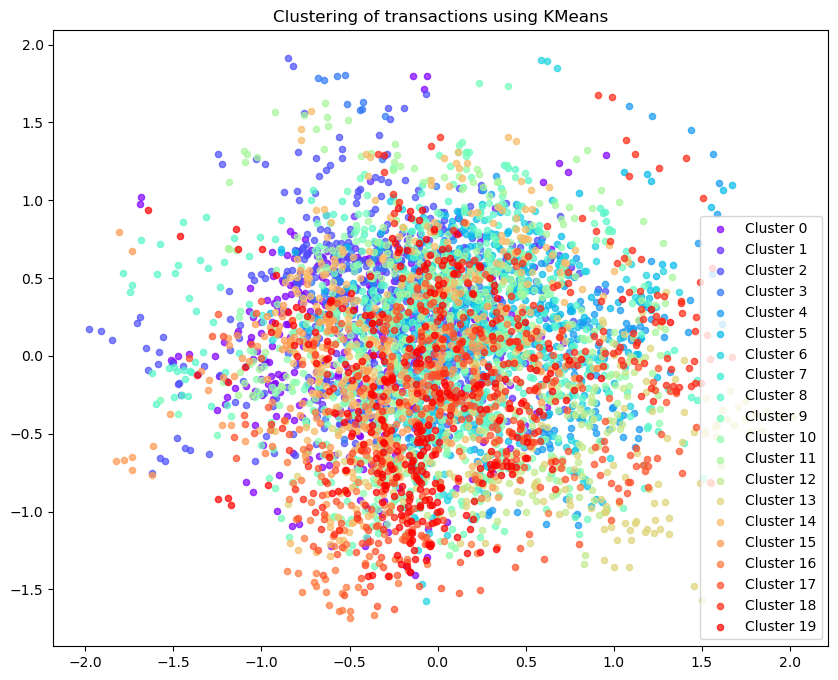

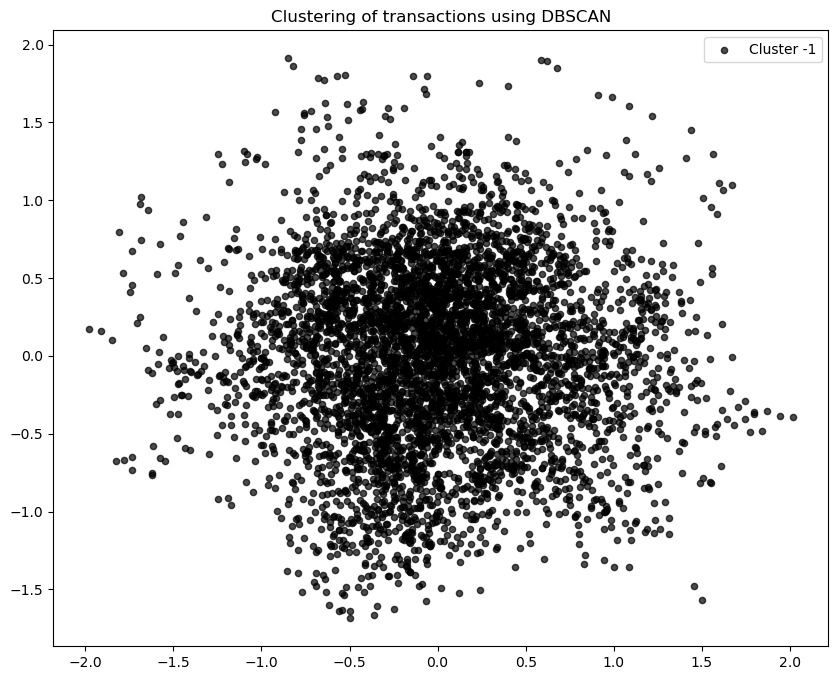

In [43]:
def main():
    df = load_data()
    df = preprocess_data(df)

    print("LINK PREDICTION ANALYSIS")
    # Build graph for link prediction
    G = build_homogeneous_graph(df)
    pyg_data, transaction_idx, transaction_ids = build_pytorch_geometric_graph(df)

    # Train link predictor
    model, embeddings = train_link_predictor(pyg_data)

    # Identify suspicious connections
    suspicious_connections = identify_suspicious_connections(model, pyg_data, transaction_ids, df)


    print("GRAPH CLUSTERING FOR FRAUD RINGS")
    # Apply clustering to identify fraud rings
    clusters, cluster_embeddings, cluster_nodes = identify_fraud_rings(G, df)

    # Visualize results (clusters)
    from sklearn.decomposition import PCA

    # Reduce dimensionality for visualization
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(cluster_embeddings)

    # Plot clustering results
    plt.figure(figsize=(12, 10))

    for method_name, labels in clusters.items():
        plt.figure(figsize=(10, 8))

        # Plot each cluster with a different color
        unique_labels = set(labels)
        colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

        for label, col in zip(unique_labels, colors):
            if label == -1:
                # Black used for noise
                col = 'k'

            class_mask = labels == label
            plt.scatter(X_2d[class_mask, 0], X_2d[class_mask, 1], c=[col],
                       label=f'Cluster {label}', alpha=0.7, s=20)

        plt.title(f'Clustering of transactions using {method_name}')
        plt.legend(loc='best')
        plt.savefig(f'{method_name}_clusters.png')
        print(f"Saved clustering visualization to '{method_name}_clusters.png'")

if __name__ == "__main__":
    main()